<a href="https://colab.research.google.com/github/AxelBadouel/machinelearningcourse/blob/main/Esercitazione_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLME: MultiLayer Perceptron

Welcome to this lesson. We are going to implement our first neural network: a multilayer perceptron!!

![img](https://i.redd.it/gq31ipgyj3v61.png)

## A quick recap of what an MLP is:

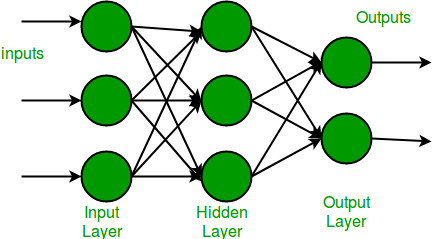

More in details here's what happens in each neuron. Always remember that after the weighted sum the non-linear activation follows.


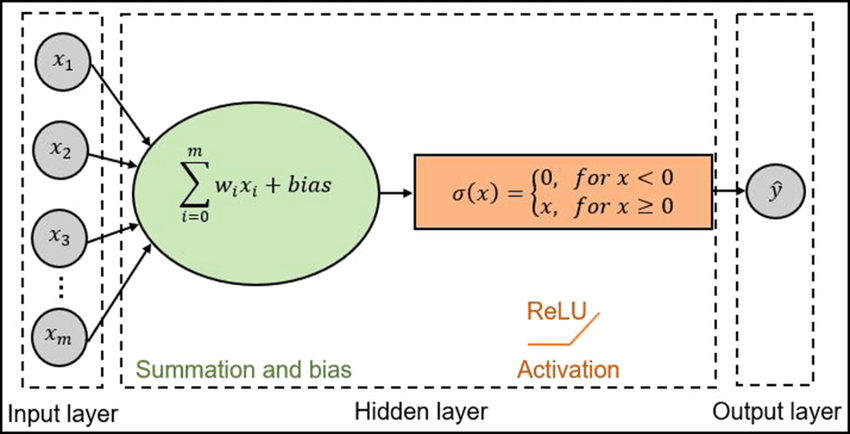

## 1 Non-linear regression using an MLP

In this first exercise, we will go back to solving a regression problem, similar to what we have done in our lecture on linear regression and polynomial regression. However, this time we will use a MLP as our model. As usual, let's start with some imports.


Notably, we will use the [torch.nn](https://pytorch.org/docs/stable/nn.html), which provides basic building blocks for building a neural network.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from tqdm.notebook import trange, tqdm
warnings.filterwarnings('ignore')

###1.1 Data-generation process: true model & training data





The &ldquo;true model&rdquo; is a constructed non-linear function $y = f(x)$.
Here is its definition and a plot to show what the &ldquo;ground truth&rdquo; looks like.



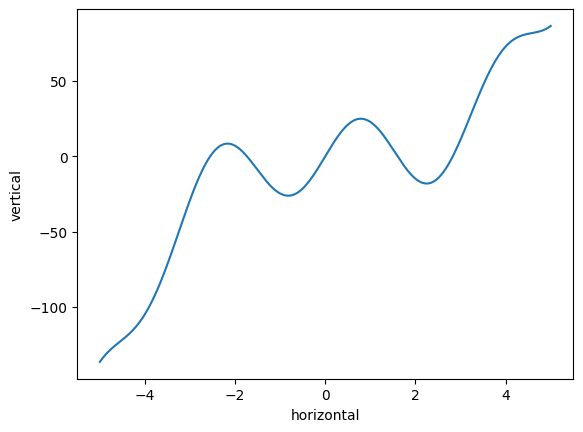

In [2]:
##################################################
## ground-truth model
##################################################

def goalFun(x):
    return(x**3 - x**2 + 25 * np.sin(2*x))

# create linear sequence (x) and apply goalFun (y)
x1 = np.linspace(start = -5, stop =5, num = 1000)
y = goalFun(x1)

# plot the function
d = pd.DataFrame({'horizontal' : x1, 'vertical' : y})
sns.lineplot(data = d, x = 'horizontal', y = 'vertical')
plt.show()

The training data consists of 100 pairs of  $(x,y)$ values.
Each pair is generated by first sampling an $x$ value from a uniform distribution.
For each sampled $x$, we compute the value of the target function $f(x)$ and add Gaussian noise to it.



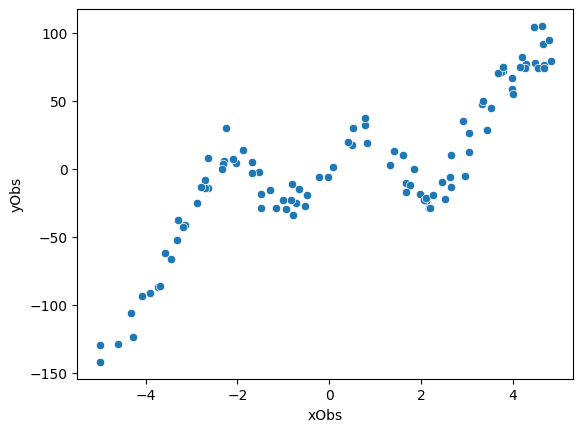

In [9]:
##################################################
## generate training data (with noise)
##################################################

nObs = 100 # number of observations

# get noise around y observations
yNormal = torch.distributions.Normal(loc=0.0, scale=10)
yNoise  = yNormal.sample([nObs])

# get observations
xObs = 10*torch.rand([nObs])-5    # uniform from [-5,5]
yObs = xObs**3 - xObs**2 + 25 * torch.sin(2*xObs) + yNoise

# plot the data
d = pd.DataFrame({'xObs' : xObs, 'yObs' : yObs})
sns.scatterplot(data = d, x = 'xObs', y = 'yObs')
plt.show()

###1.2 Defining the model using an MLP



As in our previous exercises, our model should map a single scalar $x$ onto another scalar $y$.
This time, we will use a 3-layer MLP, each hidden layer with dimension 10:



In [10]:
##################################################
## network dimension parameters
##################################################

nInput = 1
nHidden = 10 # number of neurons in hidden layers
nOutput = 1

PyTorch defines a special-purpose class called `nn.Module` from which pre-defined neural networks or custom-made networks inherit the structure and basic functionality.
Below, we define our feed-forward neural network as a class extending `nn.Module`.
Minimally, we have to define two functions for this to work:

1.  the **initialization** function `__init__` which defines which variables (mostly, but not exclusively: parameters) our model has (using `nn.Linear` instantiates a linear layer with all the trainable parameters (weights and biases) implicitly);
2.  the **forward pass** which takes the model's input and computes the corresponding prediction given the current parameter values.

Since PyTorch allows flexibility in how to define neural network modules, we look at two variants below, one explicit and one more concise.
They implement the exact same model and work the same way eventually.



#### Verbose model definition



In [11]:
##################################################
## set up multi-layer perceptron w/ PyTorch
##    -- explicit version --
##################################################

class MLPexplicit(nn.Module):
    '''
    Multi-layer perceptron for non-linear regression.
    '''
    def __init__(self, nInput, nHidden, nOutput):
        super(MLPexplicit, self).__init__()
        self.nInput  = nInput
        self.nHidden = nHidden
        self.nOutput = nOutput
        self.linear1 = nn.Linear(self.nInput, self.nHidden)   # layer 1
        self.linear2 = nn.Linear(self.nHidden, self.nHidden)  # layer 2
        self.linear3 = nn.Linear(self.nHidden, self.nHidden)  # layer 3
        self.linear4 = nn.Linear(self.nHidden, self.nOutput)  # layer 4
        self.ReLU    = nn.ReLU()

    def forward(self, x):
        h1 = self.ReLU(self.linear1(x))
        h2 = self.ReLU(self.linear2(h1))
        h3 = self.ReLU(self.linear3(h2))
        output = self.linear4(h3)
        return(output)

mlpExplicit = MLPexplicit(nInput, nHidden, nOutput)

We can access the current parameter values of this model instance like so:



In [13]:
for name, param in mlpExplicit.named_parameters():
    if param.requires_grad:
        print(f"Parameter: {name}")
        print(f"Shape: {tuple(param.shape)}")
        print(param.detach().cpu().numpy().round(4))
        print("-" * 100
        )

Parameter: linear1.weight
Shape: (10, 1)
[[-0.4966]
 [-0.345 ]
 [-0.6897]
 [ 0.8151]
 [-0.7168]
 [ 0.499 ]
 [ 0.1157]
 [-0.7219]
 [ 0.192 ]
 [ 0.0393]]
----------------------------------------------------------------------------------------------------
Parameter: linear1.bias
Shape: (10,)
[-0.1275  0.3118 -0.8805  0.8224 -0.4803  0.0945  0.3189 -0.5935  0.1922
 -0.2889]
----------------------------------------------------------------------------------------------------
Parameter: linear2.weight
Shape: (10, 10)
[[-0.212  -0.0261  0.2605  0.1312 -0.0517  0.2024  0.2789 -0.1    -0.1844
   0.2686]
 [-0.2923  0.2974 -0.244  -0.016  -0.0371 -0.0426  0.1391 -0.1883  0.2692
  -0.312 ]
 [-0.0869 -0.2846 -0.2554 -0.0861 -0.1008 -0.2677  0.2956  0.1179 -0.0949
   0.112 ]
 [ 0.1556  0.0379  0.2455  0.1153 -0.1143 -0.2568 -0.1488 -0.2686 -0.0733
  -0.2461]
 [ 0.2908 -0.3059 -0.0728 -0.1053 -0.1135  0.2121 -0.2975  0.1608 -0.1305
   0.3055]
 [-0.071  -0.2917 -0.0563  0.1444  0.2681  0.1972 -0.2313 -

#### Concise model definition



Here is another, more condensed definition of the same NN model, which uses the `nn.Sequantial` function to neatly chain components, thus defining the model parameters and the forward pass in one swoop.



In [14]:
##################################################
## set up multi-layer perceptron w/ PyTorch
##    -- condensed version --
##################################################

class MLPcondensed(nn.Module):
    '''
    Multi-layer perceptron for non-linear regression.
    '''
    def __init__(self, nInput, nHidden, nOutput):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(nInput, nHidden),
            nn.ReLU(),
            nn.Linear(nHidden, nHidden),
            nn.ReLU(),
            nn.Linear(nHidden, nHidden),
            nn.ReLU(),
            nn.Linear(nHidden, nOutput)
        )

    def forward(self, x):
        return(self.layers(x))

mlpCondensed = MLPcondensed(nInput, nHidden, nOutput)

Here you can select which one to use in the following.



In [15]:
# which model to use from here onwards
# model = mlpExplicit
model = mlpCondensed

### 1.3 Preparing the training data



Data pre-processing is a tedious job, but an integral part of machine learning.
In order to have a clean interface between data processing and modeling, we would ideally like to have a common data format to feed data into any kind of model.
That also makes sharing and reusing data sets much less painful.

As seen in previous lectures, we can create a custom dataset and a dataloader for it.

In [21]:
##################################################
## representing train data as a Dataset object
##################################################

class nonLinearRegressionData(Dataset):
    '''
    Custom 'Dataset' object for our regression data.
    Must implement these functions: __init__, __len__, and __getitem__.
    '''

    def __init__(self, xObs, yObs):
        self.xObs = torch.reshape(xObs, (len(xObs), 1))   #the dataloader expects data like that
        self.yObs = torch.reshape(yObs, (len(yObs), 1))

    def __len__(self):
        return(len(self.xObs))

    def __getitem__(self, idx):
        return(xObs[idx], yObs[idx])

# instantiate Dataset object for current training data
d = nonLinearRegressionData(xObs, yObs)
train_d, validaion_d = torch.utils.data.random_split(d, [90, 10])

# instantiate DataLoader
#    we use the 4 batches of 25 observations each (full data  has 100 observations)
#    we also shuffle the data
train_dataloader = DataLoader(train_d, batch_size=25 , shuffle=True)
#validation_dataloader = DataLoader(validation_d, batch_size=25 , shuffle=True)

We can test the iterable that we create, just to inspect how the data will be delivered later on:



In [17]:
for i, data in enumerate(train_dataloader, 0):
    input, target = data
    print(f"Batch {i}\n")
    print("In: ", input)
    print("Out:", target,"\n")

Batch 0

In:  tensor([-0.4846,  2.0710, -0.5344,  1.6644,  4.7916,  1.6778,  1.8428, -4.5946,
         4.4661, -1.4806,  4.6599, -2.6429,  4.6914,  4.2979,  0.0839,  1.3176,
         4.6884,  0.7756, -2.3152,  2.4532, -0.2216, -0.6586, -3.9124, -2.7035,
         2.1133])
Out: tensor([ -19.4677,  -22.5595,  -27.2640,  -10.2875,   95.1128,  -16.8460,
           0.2317, -128.5058,  104.4403,  -18.6521,   92.1023,    8.0913,
          76.2277,   77.5272,    1.6491,    2.7774,   73.9895,   32.0537,
           3.4508,   -9.5267,   -5.9834,  -14.8786,  -91.6409,  -13.8342,
         -21.4276]) 

Batch 1

In:  tensor([ 3.7517, -1.0123,  1.9850,  2.5297,  3.5237,  2.6404,  0.4959,  2.6624,
        -2.3308,  3.0502, -2.0928,  0.7870,  0.5291, -0.8116, -4.0843, -2.6492,
         3.0385, -1.2796, -3.5761, -2.2402,  2.6531, -3.6774, -2.8781, -1.6711,
        -4.9861])
Out: tensor([  71.5137,  -22.6702,  -18.6635,  -22.3703,   44.6530,   -6.1387,
          17.2409,  -13.5223,   -0.2087,   12.1158,   

### 1.3 Training the model



We can now train the model.
Note that we need to slightly reshape the input data to have the model compute the batched input correctly.
FOR MORE INFORMATION, SEARCH TRAINING LOOP PYTORCH.
Note, training for too long may cause overfitting. This is a problem with Neural Networks.


cpu


  0%|          | 0/10000 [00:00<?, ?it/s]

Loss after epoch 10000: 630.409
Training process has finished.


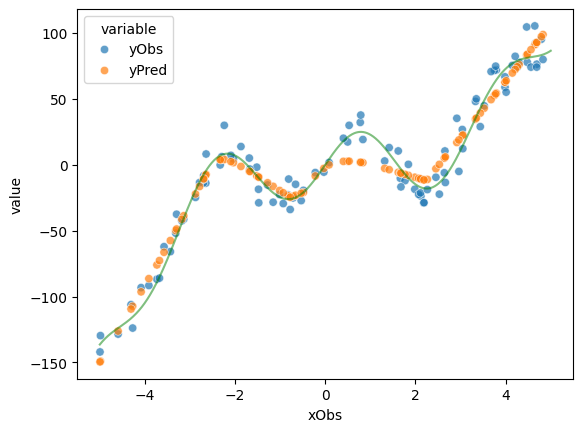

In [20]:
##################################################
## training the model
##################################################

# Select device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = MLPcondensed(nInput, nHidden, nOutput)
# model = MLPexplicit(nInput, nHidden, nOutput)
model = model.to(device)

# Define the loss function and optimizer
loss_function = nn.MSELoss()
loss_function = loss_function.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # lr = learning rate. Here it is set to 10^-4
nTrainSteps = 10000
nEpochsPrint = 10000 # More epochs should make the model better. But to high and you'll have overfitting

# Run the training loop
for epoch in tqdm(range(0, nTrainSteps)):

  # Set current loss value
  current_train_loss = 0.0

  # Iterate over the DataLoader for training data and load each batch
  for i, data in enumerate(train_dataloader, 0):
    # Get inputs
    inputs, targets = data
    inputs, targets = inputs.to(device), targets.to(device)
    # Zero the gradients
    optimizer.zero_grad()
    # Perform forward pass (make sure to supply the input in the right way) IIt makes a prediction for the batch using the current weights
    outputs = model(torch.reshape(inputs, (len(inputs), 1))).squeeze()
    # Compute loss
    loss = loss_function(outputs, targets)
    # Perform backward pass computing the gradient
    loss.backward()
    # Perform optimization. It adjusts the learning weight. This is where the learning actually happens
    optimizer.step()
    # Print statistics
    current_train_loss += loss.item()

  if (epoch + 1) % 2000 == 0:
      print('Loss after epoch %5d: %.3f' %
            (epoch + 1, current_train_loss))
      current_train_loss = 0.0

  current_validation_loss = 0.0
 # for

# Process is complete.
print('Training process has finished.')


modelCPU=model.cpu()
yPred = np.array([modelCPU.forward(torch.tensor([o])).detach().numpy() for o in xObs]).flatten()


# plot the data
d = pd.DataFrame({'xObs' : xObs.detach().numpy(),
                  'yObs' : yObs.detach().numpy(),
                  'yPred': yPred})
dWide = pd.melt(d, id_vars = 'xObs', value_vars= ['yObs', 'yPred'])
sns.scatterplot(data = dWide, x = 'xObs', y = 'value', hue = 'variable', alpha = 0.7)
x = np.linspace(start = -5, stop =5, num = 1000)
y = goalFun(x)
plt.plot(x,y, color='g', alpha = 0.5)
plt.show()

### 📓 Homework:
You may have noticed that in the training loop, we do not perform any validation. You may try to split the training data in training and validation (use an 90%/10% split). Perhaps, you may increase slightly the training data.

After `nEpochsPrint`, compute the loss on the validation data. Make sure to set the model in evaluation first (`model.eval()`) and then put it back to training mode (`model.train()`)

## Image classification using an MLP

Now, let's move to a more difficult task. Let's try to use a MLP to classify imagesfrom the famous MNIST dataset, a dataset of 28x28 black and white images consisting of handwritten digits, 0 to 9.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/mlp-mnist.png?raw=1)

As usually, let's start with some imports

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

To ensure we get reproducible results we set the random seed for Python, Numpy and PyTorch.

In [23]:
SEED = 1234 # set the same seed in order to have the same output and make it reproducible. So we initialize the seeds of each library

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

###2.1 Loading the data

The first thing we'll do is to load the MNIST dataset. Luckily, the dataset is already available in Pytorch (check [here](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST)), so we do not have to create a custom dataset.

In [24]:
ROOT = '.data'

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 41.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.17MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.23MB/s]


Let's visualize some of these images, to get a better understanding of the data

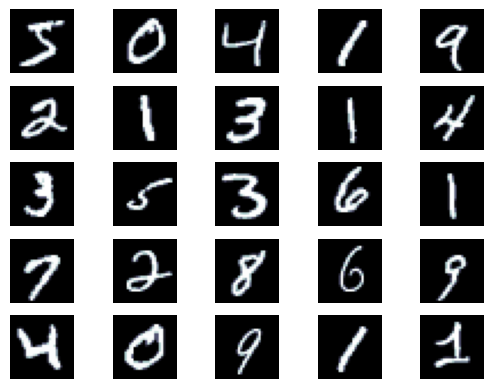

In [25]:
def plot_images_notensor(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i], cmap='bone')
        ax.axis('off')


N_IMAGES = 25

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]

plot_images_notensor(images)

However, we may want to pre-process and transform the data before using it.
Next, we want to *normalize* our data. This means we want it to have a mean of zero and a standard deviation of one.

Why do we want to do this? Normalizing our data allows our models to train faster and to also help them avoid local minima, i.e. train more reliably.

We normalize our data by subtracting the mean and dividing by the standard deviation of our dataset. First, we need to calculate the mean and standard deviation.

**Note**: it is important that the mean and standard deviation are only calculated over the training set and not the test set. We do not want to use any information at all from the test set and should only look at it when we are calculating our test loss.

To calculate the means and standard deviations we get the actual data (the images) using the `.data.` attribute of our training data, convert them into floating point numbers, and then use the built-in `mean` and `std` functions to calculate the mean and standard deviation, respectively. The image data has values between 0-255, which we want to scale between 0-1, so we divide by 255.

In [26]:
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

In [27]:
print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

Calculated mean: 0.13066047430038452
Calculated std: 0.30810779333114624


Now we've calculated our mean and standard deviation how do we actually use them? We use Torchvision's `transforms`.

A `transform` states how our data should be augmented and processed. Data augmentation involves manipulating the available training data in a way that artificially creates more training examples. We use `transforms.Compose` to built a list of transformations that will be applied to the image.

The transforms we use are:
- `RandomRotation` - randomly rotates the image between `(-x, +x)` degrees, where we have set `x = 5`. Note, the `fill=(0,)` is due to a [bug](https://github.com/pytorch/vision/issues/1759) in some versions of torchvision.
- `RandomCrop` - this first adds `padding` around our image, 2 pixels here, to artificially make it bigger, before taking a random `28x28` square crop of the image.
- `ToTensor()` - this converts the image from a PIL image into a PyTorch tensor.
- `Normalize` - this subtracts the mean and divides by the standard deviations given.

The first two transformations have to be applied before `ToTensor` as they should both be applied on a PIL image. `Normalize` should only be applied to the images after they have been converted into a tensor. See the Torchvision documentation for [transforms that should be applied to PIL images](https://pytorch.org/vision/stable/transforms.html#transforms-on-pil-image-only) and [transforms that should be applied on tensors](https://pytorch.org/vision/stable/transforms.html#transforms-on-torch-tensor-only).

We have two lists of transforms, a train and a test transform. The train transforms are to artificially create more examples for our model to train on. We do not augment our test data in the same way, as we want a consistent set of examples to evaluate our final model on. The test data, however, should still be normalized.

In [28]:
train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

Now we have defined our transforms we can then load the train and test data with the relevant transforms defined.

In [29]:
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

We can simply check the `len` of the datasets to see how many examples are within each.

In [30]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 60000
Number of testing examples: 10000


In [31]:
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

Let's load 25 images. These will have been processed through our transforms, so will be randomly rotated and cropped.

It's a good practice to see your data with your transforms applied, so you can ensure they look sensible. For example, it wouldn't make sense to flip the digits horizontally or vertically unless you are expecting to see what in your test data.

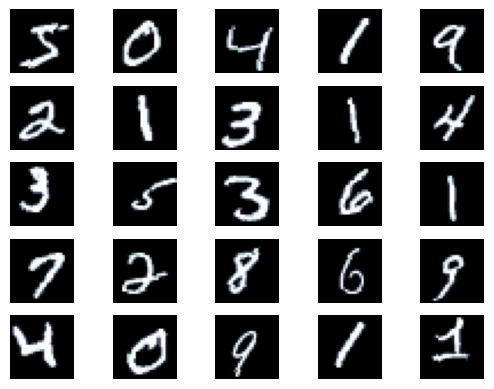

In [32]:
N_IMAGES = 25

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]

plot_images(images)

The MNIST dataset comes with a training and test set, but not a validation set. We want to use a validation set to check how well our model performs on unseen data. Why don't we just use the test data? We should only be measuring our performance over the test set once, after all training is done. We can think of the validation set as a proxy test set we are allowed to look at as much as we want.

So, let's create a validation set, taking 10% of the training set.

**Note:** the validation set should always be created from the training set. Never take the validation set from the test set. When researchers publish research papers they should be comparing performance across the test set and the only way to ensure this is a fair comparison is for all researchers to use the same test set. If the validation set is taken from the test set, then the test set is not the same as everyone else's and the results cannot be compared against each other.

First, we have to define the exact number of examples that we want to be in each split of the training/validation sets.

In [33]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

Then, we use the `random_split` function to take a random 10% of the training set to use as a validation set. The remaining 90% will stay as the training set.

In [34]:
train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

We can print out the number of examples again to check our splits are correct.

In [35]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


One thing to consider is that as the validation set has been created from the training set it has the same transforms as the training set, with the random rotating and cropping. As we want our validation set to act as a proxy for the test set, it should also be fixed, without any random augmentation.

First, let's see what 25 of the images within the validation set look like with the training transforms:

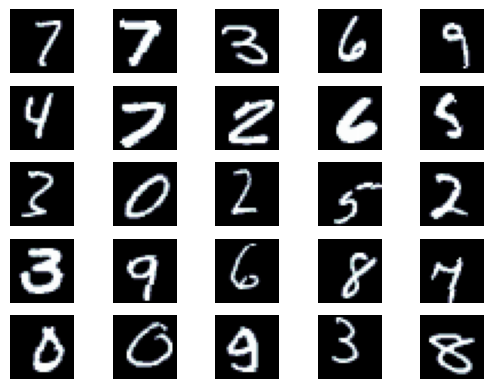

In [36]:
N_IMAGES = 25

images = [image for image, label in [valid_data[i] for i in range(N_IMAGES)]]

plot_images(images)

We can now simply replace the validation set's transform by overwriting it with our test transforms from above.

As the validation set is a `Subset` of the training set, if we change the transforms of one, then by default Torchvision will change the transforms of the other. To stop this from happening, we make a `deepcopy` of the validation data.

In [37]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

To double check we've correctly replaced the training transforms, we can view the same set of images and notice how they're more central (no random cropping) and have a more standard orientation (no random rotations).

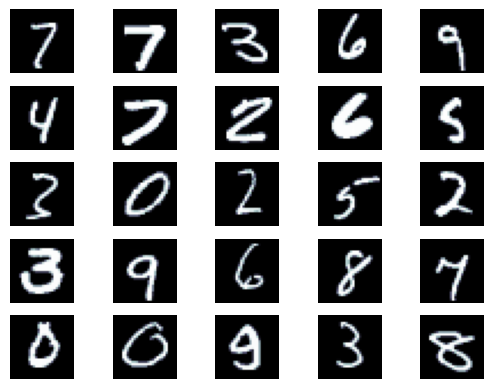

In [38]:
N_IMAGES = 25

images = [image for image, label in [valid_data[i] for i in range(N_IMAGES)]]

plot_images(images)

Next, we'll define a `DataLoader` for each of the training/validation/test sets. We can iterate over these, and they will yield batches of images and labels which we can use to train our model.

We only need to shuffle our training set as it will be used for stochastic gradient descent, and we want each batch to be different between epochs. As we aren't using the validation or test sets to update our model parameters, they do not need to be shuffled.

Ideally, we want to use the biggest batch size that we can. The 64 here is relatively small and can be increased if our hardware can handle it.

In [39]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

###2.2 Defining the Model

Our model will be a neural network, specifically a multilayer perceptron (MLP) with two hidden layers.

1.   We will flatten our 1x28x28 (1 color channel, 28 pixels height and width) image into a 784 element vector, also called 784 *features*. We flatten our input, as MLPs cannot handle two or three-dimensional data.
2.   The 784 dimensional input is passed through the first hidden layer to transform it into 250 dimensions
3. Then, another hidden layer, which will transform it to 100 dimensions.
4. Finally, an output layer which will transform it into a 10 dimensional vector. The output dimension should equal the number of classes within your data. Here we have ten digits, 0 - 9, so need our output to be 10 dimensions.

As activation function, we will use the *ReLU* (rectified linear unit). Remember that the activation function is applied elementwise.
The ReLU activation function is a popular non-linear function that is simply $max(0, x)$, where $x$ is the weighted sum of the inputs to that neuron. Other activation functions used are hyperbolic tan (tanh) and sigmoid function, however ReLU is the most commonly used.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/relu.png?raw=1)


One thing to note is that we do not use an activation function on the input directly or on the output. You should never use activation functions directly on the input, i.e. `F.relu(x)`..

Why did we choose hidden dimensions of 250 and 100 elements? Why did we only have two hidden layers? There is no magic formula to tell us how many layers to use and how many neurons to have in each layer, and there is most probably a better set of values. However, the general idea is that neural networks extract features from data. Layers closer to the input learn to extract general features (e.g. lines, curves, edges), whilst later layers combine the features extracted from the previous layer into more high level features (e.g. the intersection of two lines making a cross, multiple curves make a circle). We force our neural network to learn these features by reducing the number of neurons in each layer. This way, it has to learn to compress information by extracting only the useful and general features. Thus, we want a neural network with multiple layers and some sort of information compression (reduced number of neurons in subsequent layers).

In [40]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):
        # x = [batch size, height, width]
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        # x = [batch size, height * width]
        h_1 = F.relu(self.input_fc(x))
        # h_1 = [batch size, 250]
        h_2 = F.relu(self.hidden_fc(h_1)) # h_h_2 is the last layer representation
        # h_2 = [batch size, 100]
        y_pred = self.output_fc(h_2)
        # y_pred = [batch size, output dim]
        return y_pred, h_2

We'll define our model by creating an instance of it and setting the correct input and output dimensions.

In [41]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM)

We can also create a small function to calculate the number of trainable parameters (weights and biases) in our model - in case all of our parameters are trainable.

In [42]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

The first layer has 784 neurons connected to 250 neurons, so 784*250 weighted connections plus 250 bias terms.

The second layer has 250 neurons connected to 100 neurons, 250*100 weighted connections plus 100 bias terms.

The third layer has 100 neurons connected to 10 neurons, 100*10 weighted connections plus 10 bias terms.

$$784 \cdot 250 + 250 + 250 \cdot 100 + 100 + 100 \cdot 10 + 10 = 222,360 $$

In [43]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 222,360 trainable parameters


###2.3 Training the Model

Next, we'll define our optimizer. This is the algorithm we will use to update the parameters of our model with respect to the loss calculated on the data.

We use the *Adam* algorithm with the default parameters to update our model. Improved results could be obtained by searching over different optimizers and learning rates, however default Adam is usually a good starting off point. Check out [this](https://ruder.io/optimizing-gradient-descent/) article if you want to learn more about the different optimization algorithms commonly used for neural networks.

In [44]:
optimizer = optim.Adam(model.parameters())

Then, we define a *criterion*, PyTorch's name for a loss/cost/error function. This function will take in your model's predictions with the actual labels and then compute the loss/cost/error of your model with its current parameters.

`CrossEntropyLoss` both computes the *softmax* activation function on the supplied predictions as well as the actual loss via *negative log likelihood*.

Briefly, the softmax function is:

$$\text{softmax }(\mathbf{x}) = \frac{e^{x_i}}{\sum_j e^{x_j}}$$

This turns out 10 dimensional output, where each element is an unbounded real number, into a probability distribution over 10 elements. That is, all values are between 0 and 1, and together they all sum to 1.

Why do we turn things into a probability distribution? So we can use negative log likelihood for our loss function, as it expects probabilities. PyTorch calculates negative log likelihood for a single example via:

$$\text{negative log likelihood }(\mathbf{\hat{y}}, y) = -\log \big( \text{softmax}(\mathbf{\hat{y}})[y] \big)$$

$\mathbf{\hat{y}}$ is the $\mathbb{R}^{10}$ output, from our neural network, whereas $y$ is the label, an integer representing the class. The loss is the negative log of the class index of the softmax. For example:

$$\mathbf{\hat{y}} = [5,1,1,1,1,1,1,1,1,1]$$

$$\text{softmax }(\mathbf{\hat{y}}) = [0.8585, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157]$$

If the label was class zero, the loss would be:

$$\text{negative log likelihood }(\mathbf{\hat{y}}, 0) = - \log(0.8585) = 0.153 \dots$$

If the label was class five, the loss would be:

$$\text{negative log likelihood }(\mathbf{\hat{y}}, 5) = - \log(0.0157) = 4.154 \dots$$

So, intuitively, as your model's output corresponding to the correct class index increases, your loss decreases.

In [45]:
criterion = nn.CrossEntropyLoss()

We then define `device`. This is used to place your model and data on to a GPU, if you have one.

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


We place our model and criterion on to the device by using the `.to` method.

In [48]:
model = model.to(device)
criterion = criterion.to(device)

Next, we'll define a function to calculate the accuracy of our model. This takes the index of the highest value for your prediction and compares it against the actual class label. We then divide how many our model got correct by the amount in the batch to calculate accuracy across the batch.

In [49]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

We finally define our training loop.

This will:
- put our model into `train` mode
- iterate over our dataloader, returning batches of (image, label)
- place the batch on to our GPU, if we have one
- clear the gradients calculated from the last batch
- pass our batch of images, `x`, through to model to get predictions, `y_pred`
- calculate the loss between our predictions and the actual labels
- calculate the accuracy between our predictions and the actual labels
- calculate the gradients of each parameter
- update the parameters by taking an optimizer step
- update our metrics

Some layers act differently when training and evaluating the model that contains them, hence why we must tell our model we are in "training" mode. The model we are using here does not use any of those layers, however it is good practice to get used to putting your model in training mode.

In [50]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train() # traintraining calculating the gradient

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x) # take y_y_pred ignore the other things coming out of model()

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

The evaluation loop is similar to the training loop. The differences are:
- we put our model into evaluation mode with `model.eval()`
- we wrap the iterations inside a `with torch.no_grad()`
- we do not zero gradients as we are not calculating any
- we do not calculate gradients as we are not updating parameters
- we do not take an optimizer step as we are not calculating gradients

`torch.no_grad()` ensures that gradients are not calculated for whatever is inside the `with` block. As our model will not have to calculate gradients, it will be faster and use less memory.

In [54]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval() # no need for gradient as there is no back propagation

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

The final step before training is to define a small function to tell us how long an epoch took.

In [55]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

We're finally ready to train!

During each epoch we calculate the training loss and accuracy, followed by the validation loss and accuracy. We then check if the validation loss achieved is the best validation loss we have seen. If so, we save our model's parameters (called a `state_dict`).

In [57]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 46s
	Train Loss: 0.075 | Train Acc: 97.63%
	 Val. Loss: 0.069 |  Val. Acc: 98.05%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 29s
	Train Loss: 0.076 | Train Acc: 97.64%
	 Val. Loss: 0.064 |  Val. Acc: 98.22%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 29s
	Train Loss: 0.070 | Train Acc: 97.79%
	 Val. Loss: 0.059 |  Val. Acc: 98.28%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 31s
	Train Loss: 0.065 | Train Acc: 97.93%
	 Val. Loss: 0.059 |  Val. Acc: 98.14%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 29s
	Train Loss: 0.068 | Train Acc: 97.91%
	 Val. Loss: 0.065 |  Val. Acc: 98.02%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 29s
	Train Loss: 0.065 | Train Acc: 97.93%
	 Val. Loss: 0.064 |  Val. Acc: 98.08%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 37s
	Train Loss: 0.066 | Train Acc: 97.99%
	 Val. Loss: 0.055 |  Val. Acc: 98.30%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 30s
	Train Loss: 0.063 | Train Acc: 98.06%
	 Val. Loss: 0.063 |  Val. Acc: 98.17%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 29s
	Train Loss: 0.062 | Train Acc: 98.10%
	 Val. Loss: 0.060 |  Val. Acc: 98.03%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 29s
	Train Loss: 0.061 | Train Acc: 98.10%
	 Val. Loss: 0.060 |  Val. Acc: 98.25%


Afterwards, we load our the parameters of the model that achieved the best validation loss and then use this to evaluate our model on the test set.

In [59]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

In [60]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.051 | Test Acc: 98.31%


Our model achieves 98% accuracy on the test set.

This can be improved by tweaking hyperparameters, e.g. number of layers, number of neurons per layer, optimization algorithm used, learning rate, etc.

###2.4 Examining the Model

Now we've trained our model, there are a few things we can look at. Most of these are simple exploratory analysis, but they can offer some insights into your model.

An important thing to do is check what examples your model gets wrong and ensure that they're reasonable mistakes.

The function below will return the model's predictions over a given dataset. It will return the inputs (image) the outputs (model predictions) and the ground truth labels.

In [58]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

We can then get these predictions and, by taking the index of the highest predicted probability, get the predicted labels.

In [61]:
images, labels, probs = get_predictions(model, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

Then, we can make a confusion matrix from our actual labels and our predicted labels.

In [62]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

The results seem reasonable enough, the most confused predictions-actuals are: 3-5 and 2-7.

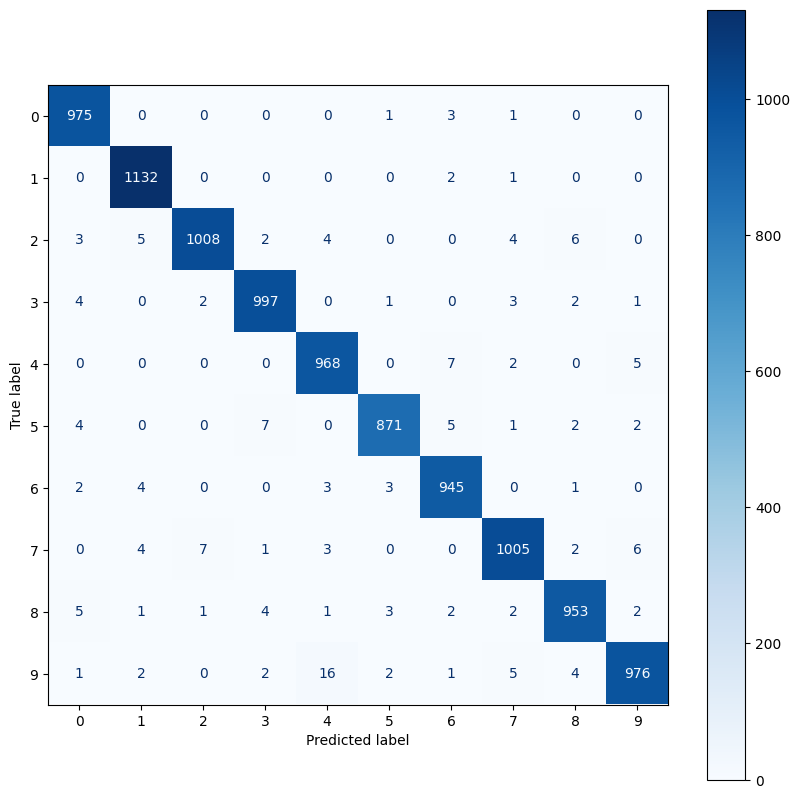

In [63]:
plot_confusion_matrix(labels, pred_labels)

Next, for each of our examples, we can check if our predicted label matches our actual label.

In [64]:
corrects = torch.eq(labels, pred_labels)
print(corrects)

tensor([True, True, True,  ..., True, True, True])


We can then loop through all of the examples over our model's predictions and store all the examples the model got incorrect into an array.

Then, we sort these incorrect examples by how confident they were, with the most confident being first.

In [65]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

We can then plot the incorrectly predicted images along with how confident they were on the actual label and how confident they were at the incorrect label.

In [66]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

Below we can see the 25 images the model got incorrect and was most confident about.

A lot of these digits are irregular, so it's difficult for the model to do well on these. The images that do look fine, if you squint you can sort of see why the model got it wrong.

Why is the neural network so confident on the irregular digits? Surely if it's a weird looking digit then the output of the softmax should be close to evenly distributed across a few digits the model isn't sure about, right? Well, no. The model has been trained to only be incredibly confident about its predictions, and thus when it sees an image it will always be confident about what it is.

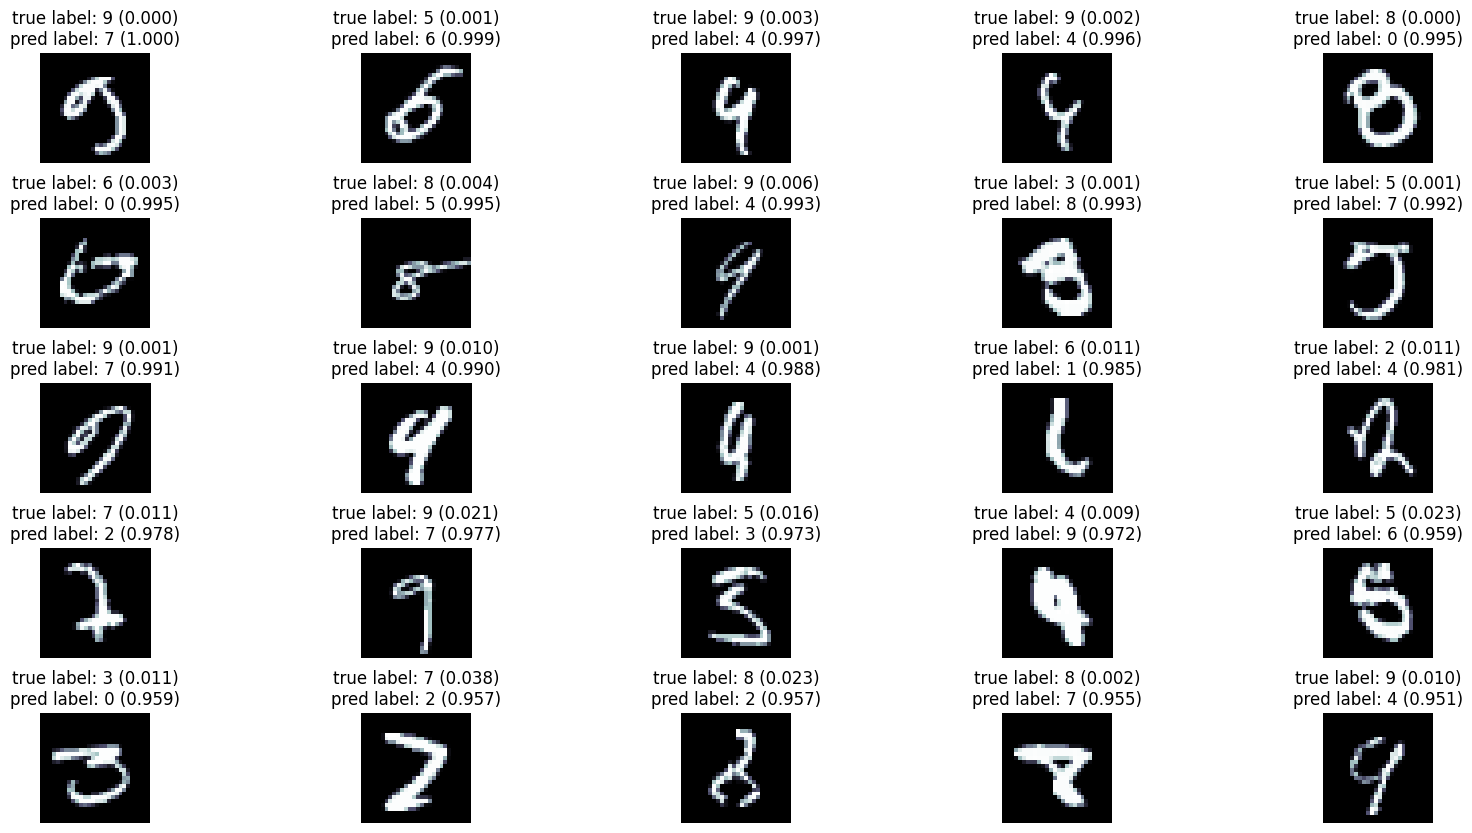

In [67]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

### 2.5 Advanced: representations visual analysis 🔍
Another thing we can do is get the output and intermediate representations from the model and try to visualize them.

The function below loops through the provided dataset and gets the output from the model and the intermediate representation from the layer before that, the second hidden layer.

In [68]:
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, intermediates, labels

We run the function to get the representations.

In [69]:
outputs, intermediates, labels = get_representations(model,
                                                     train_iterator,
                                                     device)

  0%|          | 0/844 [00:00<?, ?it/s]

The data we want to visualize is in ten dimensions and 100 dimensions. We want to get this down to two dimensions, so we can actually plot it.

The first technique we'll use is PCA (principal component analysis). First, we'll define a function to calculate the PCA of our data, and then we'll define a function to plot it.

In [70]:
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [71]:
def plot_representations(data, labels, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=labels)

First, we plot the representations from the ten dimensional output layer, reduced down to two dimensions.

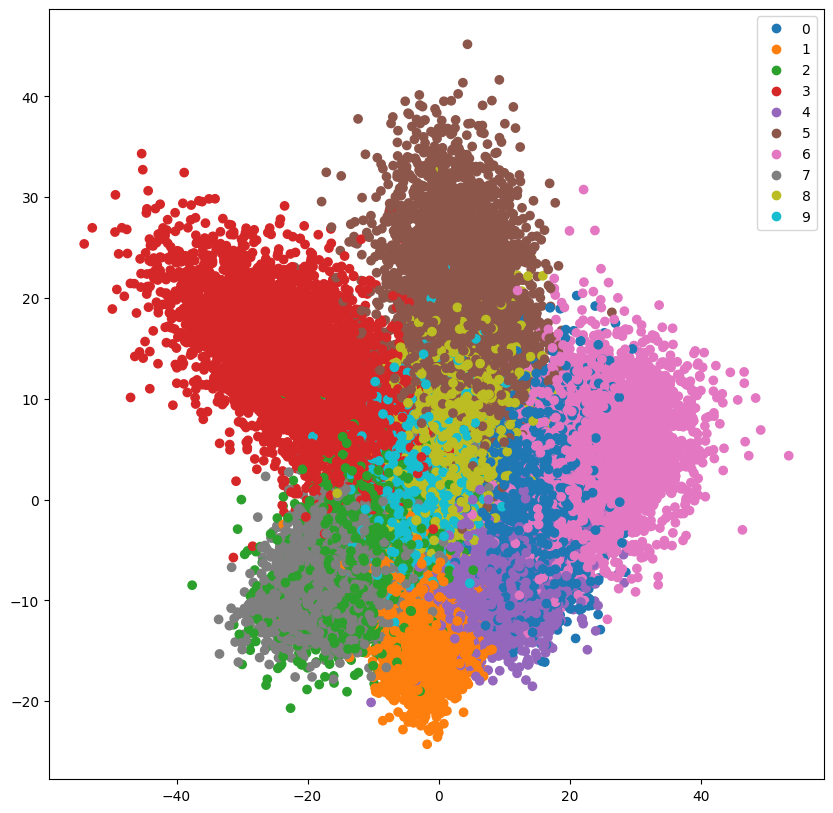

In [72]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels)

Next, we'll plot the outputs of the second hidden layer.

The clusters seem similar to the one above. In fact if we rotated the below image anti-clockwise it wouldn't be too far off the PCA of the output representations.

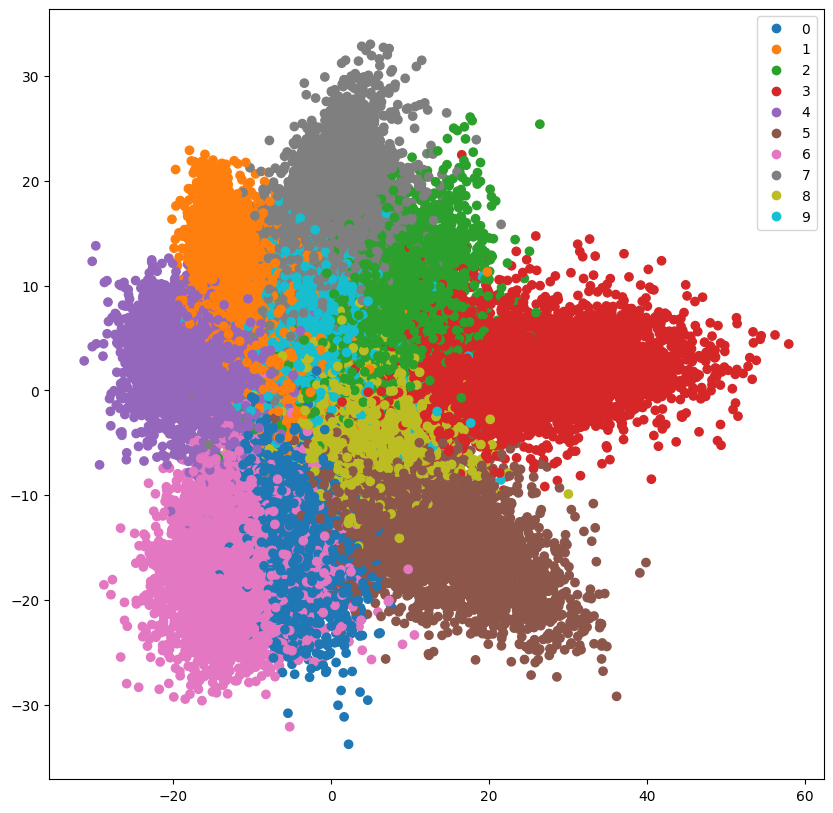

In [73]:
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels)

An alternative to PCA is t-SNE (t-distributed stochastic neighbor embedding).

This is commonly thought of as being "better" than PCA, although it can be [misinterpreted](https://distill.pub/2016/misread-tsne/).

In [74]:
def get_tsne(data, n_components=2, n_images=None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

t-SNE is very slow, so we only compute it on a subset of the representations.

The classes look very well separated, and it is possible to use [k-NN](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) on this representation to achieve decent accuracy.

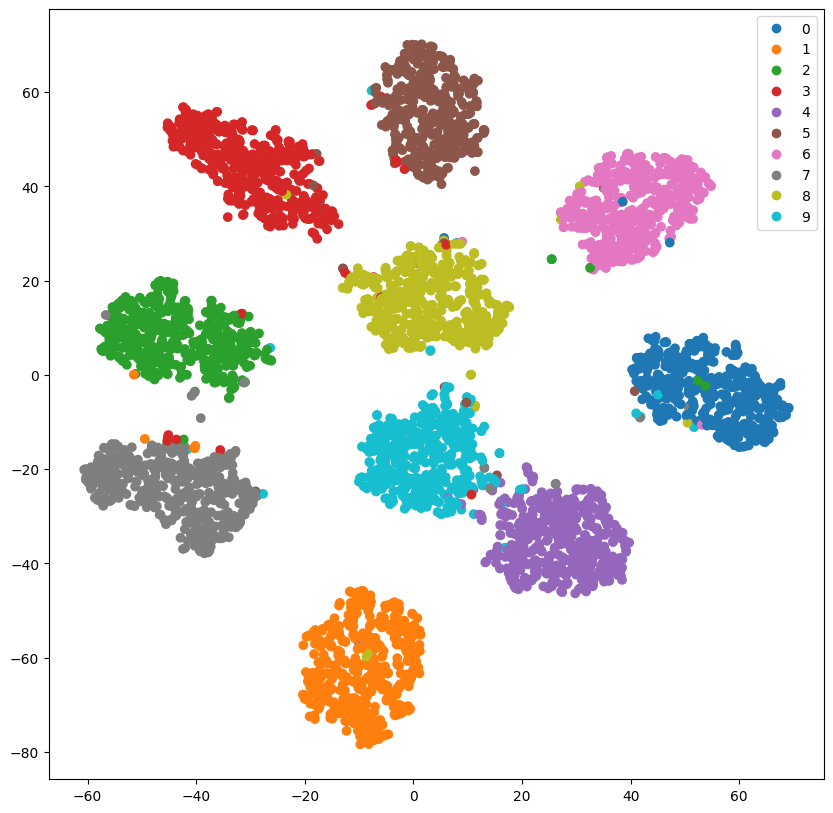

In [75]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images=N_IMAGES)
plot_representations(output_tsne_data, labels, n_images=N_IMAGES)

# We see that the plot of points is very separate shoshowing that our model has actually learned something but if it had been dome at the beginning, we would had a mess

We plot the intermediate representations on the same subset.

Again, the classes look well separated, though less so than the output representations. This is because these representations are intermediate features that the neural network has extracted and will use them in further layers to weigh up the evidence of what digit is in the image. Hence, in theory, the classes should become more separated the closer we are to the output layer, which is exactly what we see here.

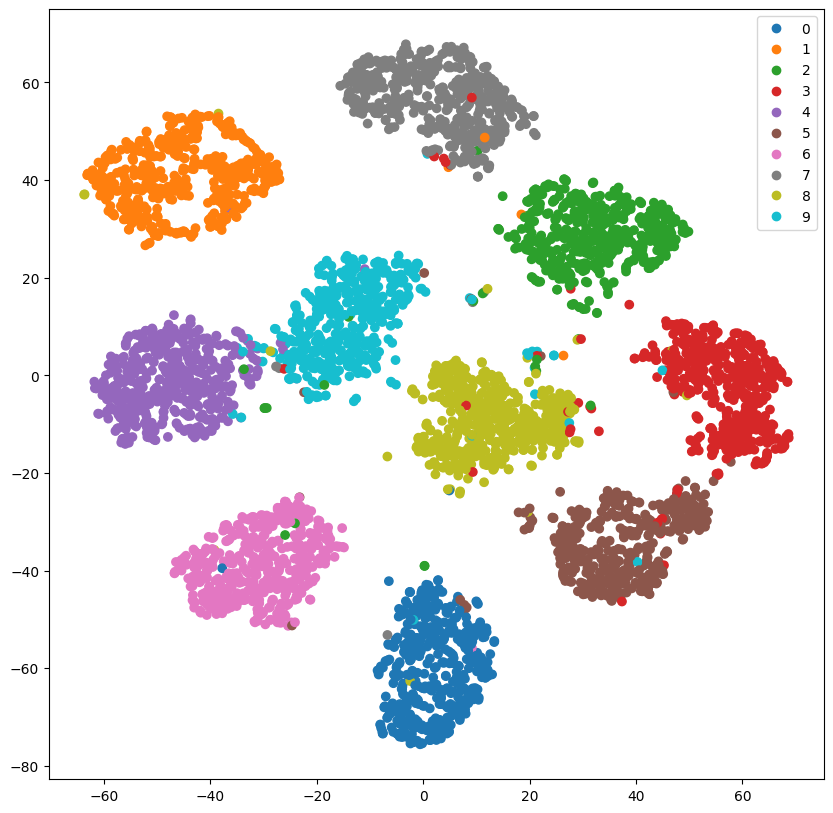

In [76]:
intermediate_tsne_data = get_tsne(intermediates, n_images=N_IMAGES)
plot_representations(intermediate_tsne_data, labels, n_images=N_IMAGES)

### 2.6 Experiment: fake digit
Another experiment we can do is try and generate fake digits.

The function below will repeatedly generate random noise and feed it through the model and find the most confidently generated digit for the desired class.

In [77]:
def imagine_digit(model, digit, device, n_iterations=50_000):

    model.eval()

    best_prob = 0
    best_image = None

    with torch.no_grad():

        for _ in trange(n_iterations):

            x = torch.randn(32, 28, 28).to(device)

            y_pred, _ = model(x)

            preds = F.softmax(y_pred, dim=-1)

            _best_prob, index = torch.max(preds[:, digit], dim=0)

            if _best_prob > best_prob:
                best_prob = _best_prob
                best_image = x[index]

    return best_image, best_prob

Let's try and generate a perfect three.

In [78]:
DIGIT = 3

best_image, best_prob = imagine_digit(model, DIGIT, device)

  0%|          | 0/50000 [00:00<?, ?it/s]

Looking at the best probability achieved, we have a digit that the model is nearly 100% confident is a three.

In [79]:
print(f'Best image probability: {best_prob.item()*100:.2f}%')

Best image probability: 100.00%


Unfortunately, the imagined perfect three just looks like random noise.

As mentioned before, the model has only been trained to be incredibly confident with its predictions, so when faced with random noise will try and classify it as something.

It is also possible that the model is *overfitting* on the training set - that there is a common pattern in handwritten threes within the training set, but it's not the pattern we want our model to learn.

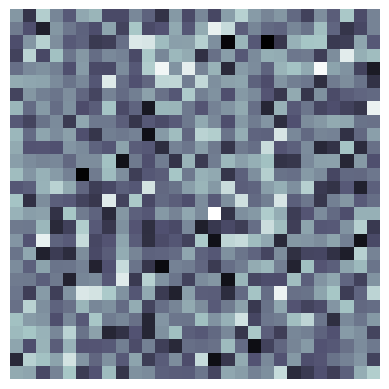

In [80]:
plt.imshow(best_image.cpu().numpy(), cmap='bone')
plt.axis('off');

###2.7 weights visualization
Finally, we can plot the weights in the first layer of our model.

The hope is that there's maybe one neuron in this first layer that's learned to look for certain patterns in the input and thus has high weight values indicating this pattern. If we then plot these weights, we should see these patterns.

In [81]:
def plot_weights(weights, n_weights):

    rows = int(np.sqrt(n_weights))
    cols = int(np.sqrt(n_weights))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(weights[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

Looking at these weights we see a few of them look like random noise but some of them do have weird patterns within them. These patterns show "ghostly" image looking shapes, but are clearly not images.

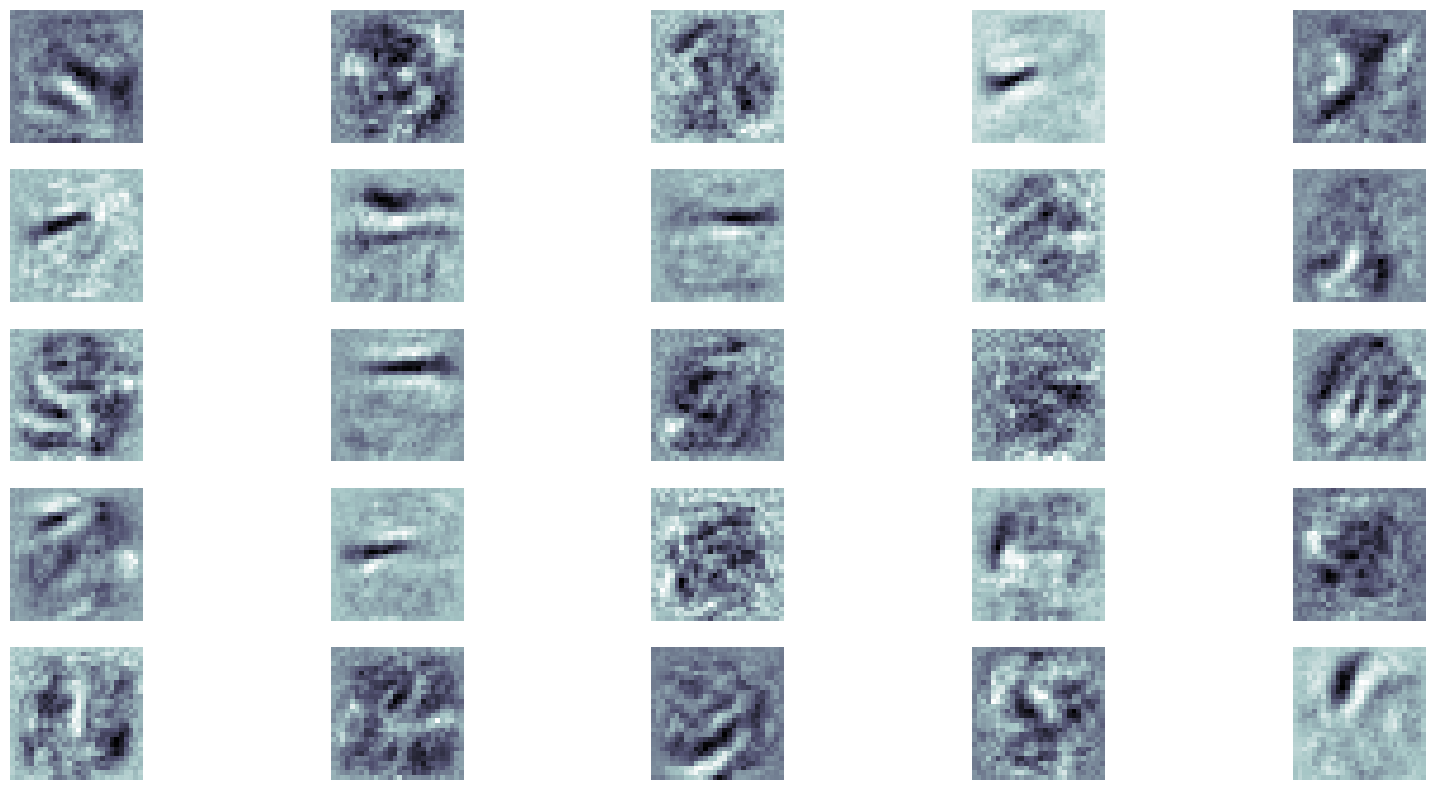

In [82]:
N_WEIGHTS = 25

weights = model.input_fc.weight.data

plot_weights(weights, N_WEIGHTS)

# Plotting the weights help us understand how the layer is reasoning